In [389]:
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune

import torchvision
from torchvision import datasets
from torchvision.transforms import Normalize
from torchvision import transforms
from torchmetrics import Accuracy

import torch.optim as optim
from cleverhans.torch.attacks.projected_gradient_descent import (projected_gradient_descent)

import quantus
import captum
from captum.attr import Saliency, IntegratedGradients, NoiseTunnel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import copy
import gc

import warnings
warnings.filterwarnings('ignore')



In [459]:
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), Normalize(mean=0.3814, std=0.3994)])
test_dataset = torchvision.datasets.FashionMNIST(root='./datasets', train=False,  download=True, transform=transformer)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, pin_memory=True)

In [461]:
class LeNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = torch.nn.Conv2d(1, 6, 5)
        self.pool_1 = torch.nn.MaxPool2d(2, 2)
        self.relu_1 = torch.nn.ReLU()
        self.conv_2 = torch.nn.Conv2d(6, 16, 5)
        self.pool_2 = torch.nn.MaxPool2d(2, 2)
        self.relu_2 = torch.nn.ReLU()
        self.fc_1 = torch.nn.Linear(256, 120)
        self.relu_3 = torch.nn.ReLU()
        self.fc_2 = torch.nn.Linear(120, 84)
        self.relu_4 = torch.nn.ReLU()
        self.fc_3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool_1(self.relu_1(self.conv_1(x)))
        x = self.pool_2(self.relu_2(self.conv_2(x)))
        x = x.view(x.shape[0], -1)
        x = self.relu_3(self.fc_1(x))
        x = self.relu_4(self.fc_2(x))
        x = self.fc_3(x)
        return x

In [463]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [43]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "lenet_fmnist.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model = LeNet().to(device)
model.load_state_dict(torch.load(MODEL_SAVE_PATH))


<All keys matched successfully>

In [45]:
x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [47]:
a_batch_integrad = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy())
a_batch_integrad[a_batch_integrad<0] = 0
a_batch_saliency = quantus.normalise_func.normalise_by_negative(Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy())
saliency = Saliency(model)
a_batch_smoothgrad = quantus.normalise_func.normalise_by_negative(NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy())


In [49]:
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

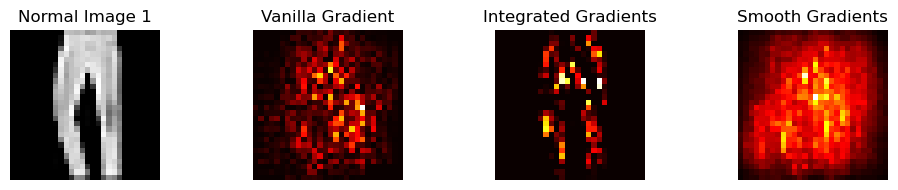

In [51]:
index = 5
nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*5., int(nr_images)))

#plot normal
axes[0].imshow(np.reshape(x_batch[index], (28,28)), cmap="grey")
axes[0].title.set_text(f"Normal Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency[index], cmap="hot")
axes[1].title.set_text(f"Vanilla Gradient")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad[index], cmap="hot")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad[index], cmap="hot")
axes[3].title.set_text(f"Smooth Gradients")
axes[3].axis("off")
# axes[4].imshow(a_batch_noisegrad[index], cmap="seismic")
# axes[4].title.set_text(f"Noise Gradients")
# axes[4].axis("off")
plt.tight_layout()


plt.show()

In [53]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "lenet_fmnist_adv.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model_adv = LeNet().to(device)
model_adv.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [55]:
x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [57]:
a_batch_integrad_adv = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model_adv).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy())
a_batch_integrad_adv[a_batch_integrad_adv<0] = 0
a_batch_saliency_adv = quantus.normalise_func.normalise_by_negative(Saliency(model_adv).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy())
saliency = Saliency(model_adv)
a_batch_smoothgrad_adv = quantus.normalise_func.normalise_by_negative(NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy())


In [59]:
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

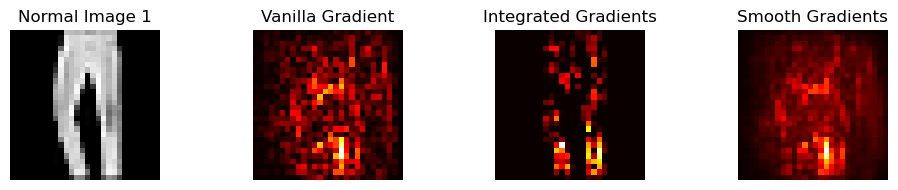

In [61]:

nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*5., int(nr_images)))

#plot normal
axes[0].imshow(np.reshape(x_batch[index], (28,28)), cmap="grey")
axes[0].title.set_text(f"Normal Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency_adv[index], cmap="hot")
axes[1].title.set_text(f"Vanilla Gradient")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad_adv[index], cmap="hot")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad_adv[index], cmap="hot")
axes[3].title.set_text(f"Smooth Gradients")
axes[3].axis("off")
# axes[4].imshow(a_batch_noisegrad[index], cmap="seismic")
# axes[4].title.set_text(f"Noise Gradients")
# axes[4].axis("off")
plt.tight_layout()


plt.show()

In [65]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "lenet_fmnist_l1_unstructured.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model_l1_unstructured = LeNet().to(device)

for name, module in model_l1_unstructured.named_modules():
    # prune 20% of weights/connections in for all hidden layaers-
    if isinstance(module, torch.nn.Linear) and name != 'fc_3':
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.2)
    
    # prune 10% of weights/connections for output layer-
    elif isinstance(module, torch.nn.Linear) and name == 'fc_3':
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.1)
        
model_l1_unstructured.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [67]:
x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [69]:
a_batch_integrad_l1 = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model_l1_unstructured).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy())
a_batch_integrad_l1[a_batch_integrad_l1<0] = 0
a_batch_saliency_l1 = quantus.normalise_func.normalise_by_negative(Saliency(model_l1_unstructured).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy())
saliency = Saliency(model_l1_unstructured)
a_batch_smoothgrad_l1 = quantus.normalise_func.normalise_by_negative(NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy())


In [71]:
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

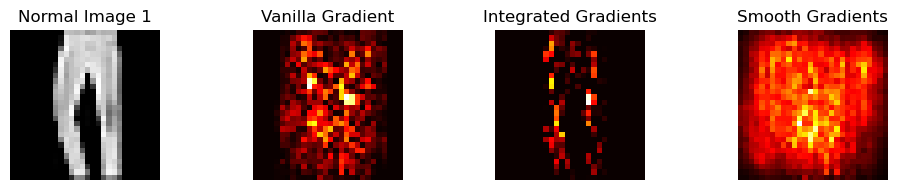

In [73]:

nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*5., int(nr_images)))

#plot normal
axes[0].imshow(np.reshape(x_batch[index], (28,28)), cmap="grey")
axes[0].title.set_text(f"Normal Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency_l1[index], cmap="hot")
axes[1].title.set_text(f"Vanilla Gradient")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad_l1[index], cmap="hot")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad_l1[index], cmap="hot")
axes[3].title.set_text(f"Smooth Gradients")
axes[3].axis("off")
# axes[4].imshow(a_batch_noisegrad[index], cmap="seismic")
# axes[4].title.set_text(f"Noise Gradients")
# axes[4].axis("off")
plt.tight_layout()


plt.show()

In [206]:
def compute_sparsity(model):
    conv1_sparsity = torch.sum(model.conv_1.weight == 0) 
    conv2_sparsity = torch.sum(model.conv_2.weight == 0)
    fc1_sparsity = torch.sum(model.fc_1.weight == 0) 
    fc2_sparsity = torch.sum(model.fc_2.weight == 0) 
    fc3_sparsity = torch.sum(model.fc_3.weight == 0) 

    num = conv1_sparsity + conv2_sparsity +fc1_sparsity + fc2_sparsity + fc3_sparsity
    denom = model.conv_1.weight.nelement() + model.conv_2.weight.nelement() + model.fc_1.weight.nelement() + model.fc_2.weight.nelement() + model.fc_3.weight.nelement()

    global_sparsity = num/denom * 100

    return global_sparsity

In [297]:
from pathlib import Path

prune_rates_global = [0.2, 0.3, 0.4, 0.5, 0.6]

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "lenet_fmnist_global.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model_global = LeNet().to(device)

parameters_to_prune = (
    (model_global.conv_1, 'weight'),
    (model_global.conv_2, 'weight'),
    (model_global.fc_1, 'weight'),
    (model_global.fc_2, 'weight'),
    (model_global.fc_3, 'weight')
)

for iter_prune_round in range(1):
    print(f"\n\nIterative Global pruning round = {iter_prune_round + 1}")
    
    # Prune layer-wise in a structured manner-
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method = prune.L1Unstructured,
        amount = prune_rates_global[iter_prune_round]
        
    )

    # Print current global sparsity level-
    print(f"LeNet-5 global sparsity = {compute_sparsity(model_global):.2f}%")

        
model_global.load_state_dict(torch.load(MODEL_SAVE_PATH))



Iterative Global pruning round = 1
LeNet-5 global sparsity = 20.00%


<All keys matched successfully>

In [299]:
x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [301]:
a_batch_integrad_global = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model_global).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy())
a_batch_integrad_global[a_batch_integrad_global<0] = 0
a_batch_saliency_global = quantus.normalise_func.normalise_by_negative(Saliency(model_global).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy())
saliency = Saliency(model_global)
a_batch_smoothgrad_global = quantus.normalise_func.normalise_by_negative(NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy())

x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

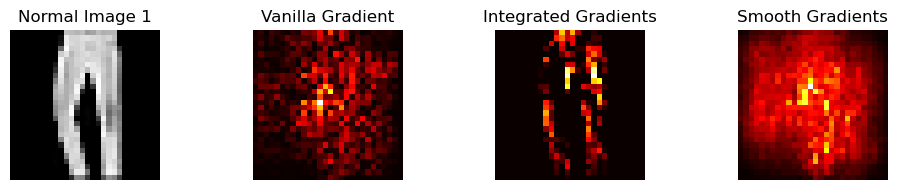

In [303]:

nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*5., int(nr_images)))

#plot normal
axes[0].imshow(np.reshape(x_batch[index], (28,28)), cmap="grey")
axes[0].title.set_text(f"Normal Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency_global[index], cmap="hot")
axes[1].title.set_text(f"Vanilla Gradient")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad_global[index], cmap="hot")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad_global[index], cmap="hot")
axes[3].title.set_text(f"Smooth Gradients")
axes[3].axis("off")
# axes[4].imshow(a_batch_noisegrad[index], cmap="seismic")
# axes[4].title.set_text(f"Noise Gradients")
# axes[4].axis("off")
plt.tight_layout()


plt.show()

In [431]:
def count_params(model):
    total_parameters = 0
    for layer, param in model.named_parameters():
        total_parameters += torch.count_nonzero(param.data)
    return total_parameters

In [465]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "lenet_fmnist_structured.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model_structured = LeNet().to(device)

# # Prune layer-wise in a structured manner-
prune.ln_structured(model_structured.conv_1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.conv_2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.fc_1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.fc_2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.fc_3, name = "weight", amount = 0.1, n = 2, dim = 0)

# Print current global sparsity level-
print(f"LeNet-5 global sparsity = {compute_sparsity(model_structured):.2f}%")

model_structured.load_state_dict(torch.load(MODEL_SAVE_PATH))


LeNet-5 global sparsity = 10.05%


<All keys matched successfully>

In [467]:
def evaluate_model(model, data, device):
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)

    with torch.no_grad():
        for x_batch, y_batch in data:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = torch.cat([logits, model(x_batch)])
            targets = torch.cat([targets, y_batch])
    
    return torch.nn.functional.softmax(logits, dim=1), targets

In [469]:
new_params = count_params(model_structured)
print(f"Pruned LeNet-5 model has {new_params} trainable parameters")

Pruned LeNet-5 model has 44426 trainable parameters


In [471]:
# Model to GPU and eval mode.
model_structured.to(device)
model_structured.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_structured, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Model test accuracy: {(100 * test_acc):.2f}%")

Model test accuracy: 82.68%


In [473]:
x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [475]:
a_batch_integrad_structured = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model_structured).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy())
a_batch_integrad_structured[a_batch_integrad_structured<0] = 0
a_batch_saliency_structured = quantus.normalise_func.normalise_by_negative(Saliency(model_structured).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy())
saliency = Saliency(model_structured)
a_batch_smoothgrad_structured = quantus.normalise_func.normalise_by_negative(NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy())

x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

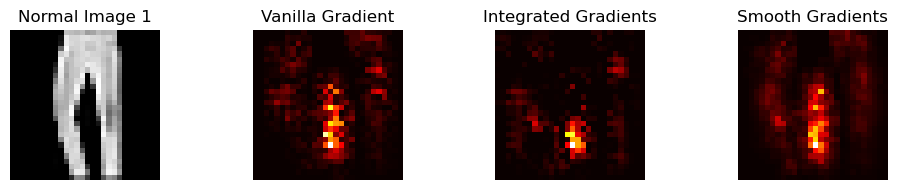

In [477]:

nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*5., int(nr_images)))

#plot normal
axes[0].imshow(np.reshape(x_batch[index], (28,28)), cmap="grey")
axes[0].title.set_text(f"Normal Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency_structured[index], cmap="hot")
axes[1].title.set_text(f"Vanilla Gradient")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad_structured[index], cmap="hot")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad_structured[index], cmap="hot")
axes[3].title.set_text(f"Smooth Gradients")
axes[3].axis("off")
# axes[4].imshow(a_batch_noisegrad[index], cmap="seismic")
# axes[4].title.set_text(f"Noise Gradients")
# axes[4].axis("off")
plt.tight_layout()


plt.show()

In [75]:
def explainer_wrapper(**kwargs):
    if kwargs["method"] == "SmoothGrad":
        return smoothgrad_explainer(**kwargs)
    else:
        return ValueError("Explanation function doesnt exist")

def smoothgrad_explainer(model, inputs, targets, abs=True, normalise=True, stdevs=0.15, nt_samples=10, *args, **kwargs):
    std = kwargs.get("std", 0.15)  # Standard deviation for input noise
    n = kwargs.get("n", 10)  # Number of noisy samples
    clip = kwargs.get("clip", False)

    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs).reshape(-1,kwargs.get("nr_channels", 1),kwargs.get("img_size", 28),kwargs.get("img_size", 28),).to(kwargs.get("device", None))
        )
    
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    assert (len(np.shape(inputs)) == 4), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size"

    if inputs.shape[0] > 1:
        explanation = torch.zeros(
            (
                n,
                inputs.shape[0],
                kwargs.get("img_size", 28),
                kwargs.get("img_size", 28),
            )
        )
    else:
        explanation = torch.zeros(
            (n, kwargs.get("img_size", 28), kwargs.get("img_size", 28))
        )
    saliency = Saliency(model)
    
    # for i in range(n):
    #     # Create noisy input by adding Gaussian noise
    #     # inputs_noisy = inputs + torch.randn_like(inputs) * std
    #     # Clip the noisy inputs to the valid range if needed
    #     if clip:
    #         inputs_noisy = torch.clip(inputs_noisy, min=0.0, max=1.0)

    #     # Compute the saliency map for the noisy input
    explanation = (
        NoiseTunnel(saliency)
        .attribute(inputs=inputs, target=targets, nt_type="smoothgrad", stdevs = stdevs, nt_samples= 10)
        .sum(axis=1)
        .reshape(-1, kwargs.get("img_size", 28), kwargs.get("img_size", 28))
        .cpu()
        .data
    )

    # explanation = explanation.mean(axis=0)
    gc.collect()
    torch.cuda.empty_cache()

    explanation = explanation.numpy()
    # Normalization (if required)
    if normalise:
        explanation = quantus.normalise_func.normalise_by_negative(explanation)

    # Convert the result to NumPy if it is still a PyTorch tensor
    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation


# # SmoothGrad
gc.collect()
torch.cuda.empty_cache()
a_batch_smoothgrad_custom = smoothgrad_explainer(model=model.to(device), 
                                        inputs=x_batch, 
                                        targets=y_batch,
                                        **{ "device": device})

gc.collect()
torch.cuda.empty_cache()
a_batch_smoothgrad_adv_custom = smoothgrad_explainer(model=model_adv.to(device), 
                                        inputs=x_batch, 
                                        targets=y_batch,
                                        **{ "device": device})


In [77]:
xai_method=["SmoothGrad"]

In [331]:
def filter_and_compute_road_saliency(model, test_loader, device):

    faithfulness = quantus.ROAD(
    noise=0.01,
    perturb_func=quantus.perturb_func.noisy_linear_imputation,
    percentages=list(range(1, 100, 5)),
    display_progressbar=False)


    score_faithfulness = []

    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(len(x_batch))
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        #print(correct_mask)
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        #print(len(x_batch))
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = faithfulness(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain,
                explain_func_kwargs = {"method": "Saliency", "softmax": False})
        #print(scores)
        
        score_faithfulness.append(scores)
        if len(score_faithfulness) > 1000:
            break
    average_values = {}
    for d in score_faithfulness:
        for key, value in d.items():
            if key in average_values:
                average_values[key] += value
            else:
                average_values[key] = value

    # Divide the sum by the number of dictionaries to get the average
    num_dicts = len(score_faithfulness)
    for key in average_values.keys():
        average_values[key] /= num_dicts

    # Display the average values
    # print("Average Values:")
    # for key, value in average_values.items():
    #     print(f"{key}: {value}")
    return average_values


In [81]:
result_normal = filter_and_compute_road_saliency(model, test_dataloader, device)

In [82]:
result_adv = filter_and_compute_road_saliency(model_adv, test_dataloader, device)

In [83]:
result_l1 = filter_and_compute_road_saliency(model_l1_unstructured, test_dataloader, device)

In [333]:
result_global = filter_and_compute_road_saliency(model_global, test_dataloader, device)

In [334]:
result_structured = filter_and_compute_road_saliency(model_structured, test_dataloader, device)

AssertionError: The elements in the attribution vector are all equal to zero, which may cause inconsistent results since many metrics rely on ordering. Recompute the explanations.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(list(result_normal.keys()),list(result_normal.values()), label='N', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_adv.values()), label='A', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_l1.values()), label='L1', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_global.values()), label='G', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_structured.values()), label='G', linestyle='--', marker='D', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("LeNet_FMNIST_SALIENCY_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [242]:
def filter_and_compute_road_ig(model, test_loader, device):

    faithfulness = quantus.ROAD(
    noise=0.01,
    perturb_func=quantus.perturb_func.noisy_linear_imputation,
    percentages=list(range(1, 100, 5)),
    display_progressbar=False)


    score_faithfulness = []

    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(len(x_batch))
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        #print(correct_mask)
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        #print(len(x_batch))
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = faithfulness(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain,
                explain_func_kwargs = {"method": "IntegratedGradients", "softmax": False})
        #print(scores)
        
        score_faithfulness.append(scores)
        if len(score_faithfulness) > 1000:
            break
    average_values = {}
    for d in score_faithfulness:
        for key, value in d.items():
            if key in average_values:
                average_values[key] += value
            else:
                average_values[key] = value

    # Divide the sum by the number of dictionaries to get the average
    num_dicts = len(score_faithfulness)
    for key in average_values.keys():
        average_values[key] /= num_dicts

    # Display the average values
    # print("Average Values:")
    # for key, value in average_values.items():
    #     print(f"{key}: {value}")
    return average_values

In [245]:
result_normal_ig = filter_and_compute_road_ig(model, test_dataloader, device)

In [92]:
result_adv_ig = filter_and_compute_road_ig(model_adv, test_dataloader, device)

In [93]:
result_l1_ig = filter_and_compute_road_ig(model_l1_unstructured, test_dataloader, device)

In [244]:
result_global_ig = filter_and_compute_road_ig(model_global, test_dataloader, device)

In [ ]:
result_structured_ig = filter_and_compute_road_ig(model_structured, test_dataloader, device)

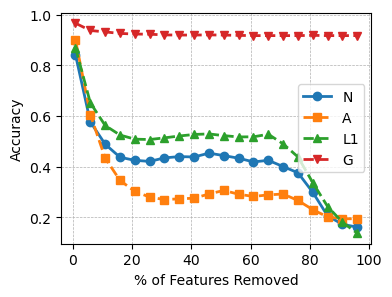

In [246]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(list(result_normal_ig.keys()),list(result_normal_ig.values()), label='N', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal_ig.keys()), list(result_adv_ig.values()), label='A', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal_ig.keys()), list(result_l1_ig.values()), label='L1', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal_ig.keys()), list(result_global_ig.values()), label='G', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal_ig.keys()), list(result_structured_ig.values()), label='G', linestyle='--', marker='D', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("LeNet_FMNIST_IG_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [247]:
def filter_and_compute_road_smooth(model, test_loader, device):

    faithfulness = quantus.ROAD(
    noise=0.01,
    perturb_func=quantus.perturb_func.noisy_linear_imputation,
    percentages=list(range(1, 100, 5)),
    display_progressbar=False)


    score_faithfulness = []

    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(len(x_batch))
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        #print(correct_mask)
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        #print(len(x_batch))
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = faithfulness(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= explainer_wrapper,
                explain_func_kwargs = {
                    "method": xai_method[0],
                    "posterior_mean": copy.deepcopy(
                        model
                        .to(device)
                        .state_dict()
                    ),
                    "mean": 1.0,
                    "std": 0.5,
                    "n": 25,
                    "device": device,
                },
        )
        #print(scores)
        
        score_faithfulness.append(scores)
        if len(score_faithfulness) > 1000:
            break
    average_values = {}
    for d in score_faithfulness:
        for key, value in d.items():
            if key in average_values:
                average_values[key] += value
            else:
                average_values[key] = value

    # Divide the sum by the number of dictionaries to get the average
    num_dicts = len(score_faithfulness)
    for key in average_values.keys():
        average_values[key] /= num_dicts

    # Display the average values
    # print("Average Values:")
    # for key, value in average_values.items():
    #     print(f"{key}: {value}")
    return average_values

In [96]:
result_normal_smooth = filter_and_compute_road_smooth(model, test_dataloader, device)

In [128]:
result_adv_smooth = filter_and_compute_road_smooth(model_adv, test_dataloader, device)

In [97]:
result_l1_smooth = filter_and_compute_road_smooth(model_l1_unstructured, test_dataloader, device)

In [248]:
result_global_smooth = filter_and_compute_road_smooth(model_global, test_dataloader, device)

In [ ]:
result_structured_smooth = filter_and_compute_road_smooth(model_structured, test_dataloader, device)

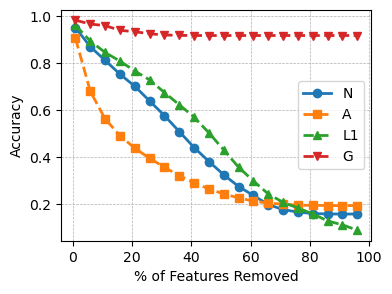

In [249]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(list(result_normal_smooth.keys()),list(result_normal_smooth.values()), label='N', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal_smooth.keys()), list(result_adv_smooth.values()), label='A', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal_smooth.keys()), list(result_l1_smooth.values()), label='L1', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal_smooth.keys()), list(result_global_smooth.values()), label='G', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal_smooth.keys()), list(result_structured_smooth.values()), label='G', linestyle='--', marker='D', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("LeNet_FMNIST_SMOOTH_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [250]:
import math
def filter_and_compute_input_stability_saliency(model, test_loader, device):
    
    metrics = quantus.RelativeInputStability(
        nr_samples =5,
        return_aggregate=False,
         disable_warnings=True,
    )
    score = []
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = metrics(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain, 
                explain_func_kwargs = {"method": "Saliency", "softmax": False})
        scores2 = np.nanmean(scores)
        score.append(scores2)
        if len(score) > 1000:
            break 
    score2=score
    return math.log(np.nanmean(score2), 10)

In [131]:
print("The relative input stability score is: ", filter_and_compute_input_stability_saliency(model, test_dataloader, device))

The relative input stability score is:  3.836493411085341


In [132]:
print("The relative input stability score is: ", filter_and_compute_input_stability_saliency(model_adv, test_dataloader, device))

The relative input stability score is:  4.058082306510594


In [133]:
print("The relative input stability score is: ", filter_and_compute_input_stability_saliency(model_l1_unstructured, test_dataloader, device))

The relative input stability score is:  6.057852554160519


In [251]:
print("The relative input stability score is: ", filter_and_compute_input_stability_saliency(model_global, test_dataloader, device))

The relative input stability score is:  0.7315936874712917


In [ ]:
print("The relative input stability score is: ", filter_and_compute_input_stability_saliency(model_structured, test_dataloader, device))

In [252]:
import math
def filter_and_compute_input_stability_ig(model, test_loader, device):
    
    metrics = quantus.RelativeInputStability(
        nr_samples =5,
        return_aggregate=False,
         disable_warnings=True,
    )
    score = []
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = metrics(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain, 
                explain_func_kwargs = {"method": "IntegratedGradients", "softmax": False})
        scores2 = np.nanmean(scores)
        score.append(scores2)
        if len(score) > 1000:
            break 
    score2=score
    return math.log(np.nanmean(score2), 10)

In [138]:
print("The relative input stability score is: ", filter_and_compute_input_stability_ig(model, test_dataloader, device))

The relative input stability score is:  4.049948504218132


In [139]:
print("The relative input stability score is: ", filter_and_compute_input_stability_ig(model_adv, test_dataloader, device))

The relative input stability score is:  -0.32887816007318976


In [140]:
print("The relative input stability score is: ", filter_and_compute_input_stability_ig(model_l1_unstructured, test_dataloader, device))

The relative input stability score is:  5.8762950269368295


In [253]:
print("The relative input stability score is: ", filter_and_compute_input_stability_ig(model_global, test_dataloader, device))

The relative input stability score is:  7.530433504687796


In [ ]:
print("The relative input stability score is: ", filter_and_compute_input_stability_ig(model_structured, test_dataloader, device))

In [311]:
import math
def filter_and_compute_input_stability_smooth(model, test_loader, device):
    
    metrics = quantus.RelativeInputStability(
        nr_samples =5,
        return_aggregate=False,
         disable_warnings=True,
    )
    score = []
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = metrics(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= explainer_wrapper,
                explain_func_kwargs = {
                    "method": xai_method[0],
                    "posterior_mean": copy.deepcopy(
                        model
                        .to(device)
                        .state_dict()
                    ),
                    "mean": 1.0,
                    "std": 0.5,
                    "n": 25,
                    "device": device,
                })
        scores2 = np.nanmean(scores)
        score.append(scores2)
        if len(score) > 1000:
            break 
    score2=score
    return math.log(np.nanmean(score2), 10)

In [142]:
print("The relative input stability score is: ", filter_and_compute_input_stability_smooth(model, test_dataloader, device))

The relative input stability score is:  -1.779705472181124


In [143]:
print("The relative input stability score is: ", filter_and_compute_input_stability_smooth(model_adv, test_dataloader, device))

The relative input stability score is:  -2.4860015753998552


In [144]:
print("The relative input stability score is: ", filter_and_compute_input_stability_smooth(model_l1_unstructured, test_dataloader, device))

The relative input stability score is:  -1.4978716785324862


In [313]:
print("The relative input stability score is: ", filter_and_compute_input_stability_smooth(model_global, test_dataloader, device))

The relative input stability score is:  -1.4989632571449232


In [ ]:
print("The relative input stability score is: ", filter_and_compute_input_stability_smooth(model_structured, test_dataloader, device))

In [273]:
def filter_and_compute_output_stability_saliency(model, test_loader, device):
    metrics = quantus.RelativeOutputStability(
        nr_samples = 5,
         return_aggregate=False,
        disable_warnings=True,
    )
    score = []
    
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = metrics(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain, 
                explain_func_kwargs = {"method": "Saliency", "softmax": False})
        scores2 = np.nanmean(scores)
        score.append(scores2)
        if len(score) > 1000:
            break 
    score2=score
    return math.log(np.nanmean(score2), 10)

In [146]:
print("The relative output stability score is: ", filter_and_compute_output_stability_saliency(model, test_dataloader, device))

The relative output stability score is:  9.572084751454355


In [147]:
print("The relative output stability score is: ", filter_and_compute_output_stability_saliency(model_adv, test_dataloader, device))

The relative output stability score is:  10.996912132130182


In [148]:
print("The relative output stability score is: ", filter_and_compute_output_stability_saliency(model_l1_unstructured, test_dataloader, device))

The relative output stability score is:  11.84982869985232


In [275]:
print("The relative output stability score is: ", filter_and_compute_output_stability_saliency(model_global, test_dataloader, device))

The relative output stability score is:  6.528035082545415


In [ ]:
print("The relative output stability score is: ", filter_and_compute_output_stability_saliency(model_structured, test_dataloader, device))

In [276]:
def filter_and_compute_output_stability_ig(model, test_loader, device):
    metrics = quantus.RelativeOutputStability(
        nr_samples = 5,
         return_aggregate=False,
        disable_warnings=True,
    )
    score = []
    
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = metrics(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain, 
                explain_func_kwargs = {"method": "IntegratedGradients", "softmax": False})
        scores2 = np.nanmean(scores)
        score.append(scores2)
        if len(score) > 1000:
            break 
    score2=score
    return math.log(np.nanmean(score2), 10)

In [150]:
print("The relative output stability score is: ", filter_and_compute_output_stability_ig(model, test_dataloader, device))

The relative output stability score is:  9.827722741897116


In [151]:
print("The relative output stability score is: ", filter_and_compute_output_stability_ig(model_adv, test_dataloader, device))

The relative output stability score is:  6.323918419509933


In [152]:
print("The relative output stability score is: ", filter_and_compute_output_stability_ig(model_l1_unstructured, test_dataloader, device))

The relative output stability score is:  11.626816231962918


In [277]:
print("The relative output stability score is: ", filter_and_compute_output_stability_ig(model_global, test_dataloader, device))

The relative output stability score is:  13.241481383601995


In [ ]:
print("The relative output stability score is: ", filter_and_compute_output_stability_ig(model_structured, test_dataloader, device))

In [314]:
def filter_and_compute_output_stability_smooth(model, test_loader, device):
    metrics = quantus.RelativeOutputStability(
        nr_samples = 5,
         return_aggregate=False,
        disable_warnings=True,
    )
    score = []
    
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = metrics(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= explainer_wrapper,
                explain_func_kwargs = {
                    "method": xai_method[0],
                    "posterior_mean": copy.deepcopy(
                        model
                        .to(device)
                        .state_dict()
                    ),
                    "mean": 1.0,
                    "std": 0.5,
                    "n": 25,
                    "device": device,
                })
        scores2 = np.nanmean(scores)
        score.append(scores2)
        if len(score) > 1000:
            break 
    score2=score
    return math.log(np.nanmean(score2), 10)

In [154]:
print("The relative output stability score is: ", filter_and_compute_output_stability_smooth(model, test_dataloader, device))

The relative output stability score is:  3.9435742953598627


In [155]:
print("The relative output stability score is: ", filter_and_compute_output_stability_smooth(model_adv, test_dataloader, device))

The relative output stability score is:  4.130943463378512


In [156]:
print("The relative output stability score is: ", filter_and_compute_output_stability_smooth(model_l1_unstructured, test_dataloader, device))

The relative output stability score is:  4.196583571492514


In [315]:
print("The relative output stability score is: ", filter_and_compute_output_stability_smooth(model_global, test_dataloader, device))

The relative output stability score is:  4.679172863158579


In [ ]:
print("The relative output stability score is: ", filter_and_compute_output_stability_smooth(model_structured, test_dataloader, device))

In [287]:
def filter_and_compute_sparsity_saliency(model, test_loader, device):
    
    sparsity = quantus.Sparseness(disable_warnings=True, return_aggregate=True)
    score_sparsity = []

    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(len(x_batch))
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        #print(correct_mask)
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        #print(len(x_batch))
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = sparsity(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain, 
                explain_func_kwargs = {"method": "Saliency", "softmax": False})
        score_sparsity.extend(scores)
        if len(score_sparsity) > 1000:
            break 
    return np.nanmean(score_sparsity), np.nanstd(score_sparsity)

In [158]:
print("The sparsity score is: ", filter_and_compute_sparsity_saliency(model, test_dataloader, device))

The sparsity score is:  (0.5740714641189001, 0.004699775798607608)


In [159]:
print("The sparsity score is: ", filter_and_compute_sparsity_saliency(model_adv, test_dataloader, device))

The sparsity score is:  (0.5299913803318058, 0.0055508668200605245)


In [160]:
print("The sparsity score is: ", filter_and_compute_sparsity_saliency(model_l1_unstructured, test_dataloader, device))

The sparsity score is:  (0.6169827774570616, 0.008690114984795235)


In [289]:
print("The sparsity score is: ", filter_and_compute_sparsity_saliency(model_global, test_dataloader, device))

The sparsity score is:  (0.9260024500469012, 0.008646629558591532)


In [ ]:
print("The sparsity score is: ", filter_and_compute_sparsity_saliency(model_structured, test_dataloader, device))

In [290]:
def filter_and_compute_sparsity_ig(model, test_loader, device):
    
    sparsity = quantus.Sparseness(disable_warnings=True, return_aggregate=True)
    score_sparsity = []

    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(len(x_batch))
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        #print(correct_mask)
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        #print(len(x_batch))
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = sparsity(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain, 
                explain_func_kwargs = {"method": "IntegratedGradients", "softmax": False})
        score_sparsity.extend(scores)
        if len(score_sparsity) > 1000:
            break 
    return np.nanmean(score_sparsity), np.nanstd(score_sparsity)

In [162]:
print("The sparsity score is: ", filter_and_compute_sparsity_ig(model, test_dataloader, device))

The sparsity score is:  (0.7646283400608169, 0.013378739640471728)


In [163]:
print("The sparsity score is: ", filter_and_compute_sparsity_ig(model_adv, test_dataloader, device))

The sparsity score is:  (0.7515817406221436, 0.01580212954837601)


In [164]:
print("The sparsity score is: ", filter_and_compute_sparsity_ig(model_l1_unstructured, test_dataloader, device))

The sparsity score is:  (0.7746628923728008, 0.01163089863474513)


In [291]:
print("The sparsity score is: ", filter_and_compute_sparsity_ig(model_global, test_dataloader, device))

The sparsity score is:  (0.9287220512823486, 0.009808548777030733)


In [ ]:
print("The sparsity score is: ", filter_and_compute_sparsity_ig(model_structured, test_dataloader, device))

In [316]:
def filter_and_compute_sparsity_smooth(model, test_loader, device):
    
    sparsity = quantus.Sparseness(disable_warnings=True, return_aggregate=True)
    score_sparsity = []

    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(len(x_batch))
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        #print(correct_mask)
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        #print(len(x_batch))
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = sparsity(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                 explain_func= explainer_wrapper,
                explain_func_kwargs = {
                    "method": xai_method[0],
                    "posterior_mean": copy.deepcopy(
                        model
                        .to(device)
                        .state_dict()
                    ),
                    "mean": 1.0,
                    "std": 0.5,
                    "n": 25,
                    "device": device,
                })
        score_sparsity.extend(scores)
        if len(score_sparsity) > 1000:
            break 
    return np.nanmean(score_sparsity), np.nanstd(score_sparsity)

In [166]:
print("The sparsity score is: ", filter_and_compute_sparsity_smooth(model, test_dataloader, device))

The sparsity score is:  (0.36357905257664214, 0.00432309230026499)


In [167]:
print("The sparsity score is: ", filter_and_compute_sparsity_smooth(model_adv, test_dataloader, device))

The sparsity score is:  (0.39372025962822776, 0.007185495724816748)


In [168]:
print("The sparsity score is: ", filter_and_compute_sparsity_smooth(model_l1_unstructured, test_dataloader, device))

The sparsity score is:  (0.3609065714029214, 0.00422286660671148)


In [317]:
print("The sparsity score is: ", filter_and_compute_sparsity_smooth(model_global, test_dataloader, device))

The sparsity score is:  (0.3858592938168103, 0.004317550104549729)


In [ ]:
print("The sparsity score is: ", filter_and_compute_sparsity_smooth(model_structured, test_dataloader, device))